In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import ensemble

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [3]:
train_data=pd.read_csv("data/train.csv")
test_data=pd.read_csv("data/test.csv")

# Preprocessing

In [4]:
print train_data.shape
print test_data.shape

(891, 12)
(418, 11)


##### Filling the Null value for train and test data 

In [5]:
print "Train columns with null values:" 
print train_data.isnull().sum()

Train columns with null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
print "Test columns with null values:" 
print test_data.isnull().sum()

Test columns with null values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


##### Variable Tramsformation 

In [7]:
all_data=[train_data,test_data]
for dataset in all_data:
    dataset["Age"].fillna(dataset['Age'].mean(), inplace = True)
    dataset["Fare"].fillna(dataset['Fare'].median(), inplace = True)
    dataset["Embarked"].fillna(dataset['Embarked'].mode(), inplace = True)

In [8]:
train_data.drop(['PassengerId','Cabin', 'Ticket'],axis=1,inplace=True)

In [9]:
train_data.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,NaN,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,NaN,13.002015,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,NaN,29.699118,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,31.000000,NaN


In [10]:
for dataset in all_data:
    dataset["familySize"]=dataset["SibSp"]+dataset["Parch"]+1
    dataset["isAlone"]=1
    dataset["isAlone"].loc[dataset['familySize'] > 1] = 0
    dataset["title"]=dataset.apply(lambda x: x["Name"].split(",")[1].split(".")[0].strip(" \n"),axis=1)
    dataset["FareBin"]=pd.qcut(dataset['Fare'], 4)
    dataset["AgeBin"]=pd.cut(dataset["Age"],5)

F:\Anaconda\new\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,familySize,isAlone,title,FareBin,AgeBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.336, 32.252]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.252, 48.168]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.336, 32.252]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.252, 48.168]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.252, 48.168]"


In [12]:
train_data["title"].loc[(train_data["title"]!="Mr") &
                       (train_data["title"]!="Miss") &
                       (train_data["title"]!="Mrs") &
                       (train_data["title"]!="Master")]="Other"

In [13]:
train_data["title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: title, dtype: int64

In [14]:
#original variables x
x_vals=['Sex','Pclass', 'Embarked', 'title','SibSp', 'Parch', 'Age', 'Fare', 'familySize', 'isAlone']

#Target Y
target=["Survived"]

#Code categorical data
#Transform categorical data into numerical value
label=preprocessing.LabelEncoder()
for dataset in all_data:
    dataset["sexCode"]=label.fit_transform(dataset["Sex"])
    dataset["embarkedCode"]=label.fit_transform(dataset["Embarked"])
    dataset["titleCode"]=label.fit_transform(dataset["title"])
    dataset["ageCode"]=label.fit_transform(dataset["AgeBin"])
    dataset["fareCode"]=label.fit_transform(dataset["FareBin"])

raw_x_vals = ['sexCode','Pclass', 'embarkedCode', 'titleCode','SibSp', 'Parch', 'Age', 'Fare']    

bin_x_vals=['sexCode','Pclass', 'embarkedCode', 'titleCode', 'ageCode', 
            'fareCode', 'familySize']

dummy_data=pd.get_dummies(train_data[x_vals])
dummy_x_vals=dummy_data.columns.tolist()


F:\Anaconda\new\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [15]:
print raw_x_vals
print bin_x_vals
print dummy_x_vals

['sexCode', 'Pclass', 'embarkedCode', 'titleCode', 'SibSp', 'Parch', 'Age', 'Fare']
['sexCode', 'Pclass', 'embarkedCode', 'titleCode', 'ageCode', 'fareCode', 'familySize']
['Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'familySize', 'isAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Other']


In [16]:
dummy_data.head()

,Pclass,SibSp,Parch,Age,Fare,familySize,isAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


In [17]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,familySize,isAlone,title,FareBin,AgeBin,sexCode,embarkedCode,titleCode,ageCode,fareCode
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.336, 32.252]",1,3,2,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.252, 48.168]",0,1,3,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.336, 32.252]",0,3,1,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.252, 48.168]",0,3,3,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.252, 48.168]",1,3,2,2,1


##### Spliting data  

In [18]:
train_raw_x,test_raw_x,train_raw_y,test_raw_y=model_selection.train_test_split(train_data[raw_x_vals],
                                                                               train_data[target],random_state=0)

train_bin_x,test_bin_x,train_bin_y,test_bin_y=model_selection.train_test_split(train_data[bin_x_vals],
                                                                               train_data[target],random_state=0)
train_dum_x,test_dum_x,train_dum_y,test_dum_y=model_selection.train_test_split(dummy_data[dummy_x_vals],
                                                                               train_data[target],random_state=0)

In [19]:
print "raw train data shape : {}".format(train_data.shape)
print "train_raw shape : {}".format(train_raw_x.shape)
print "test_raw shape : {}".format(test_raw_x.shape)

raw train data shape : (891, 19)
train_raw shape : (668, 8)
test_raw shape : (223, 8)


In [20]:
for val in train_data:
    if train_data[val].dtypes!="float64" and val!="Survived" and val !="Name":
        print "Survival ratio divided by : "+str(val)
        print train_data[[val, target[0]]].groupby(val,as_index=False).mean()
        print "-"*20

Survival ratio divided by : Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
Survival ratio divided by : Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------------
Survival ratio divided by : SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
Survival ratio divided by : Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
--------------------
Survival ratio divided by : Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
--------------------
Survival ratio divided by : familySize
   familySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           

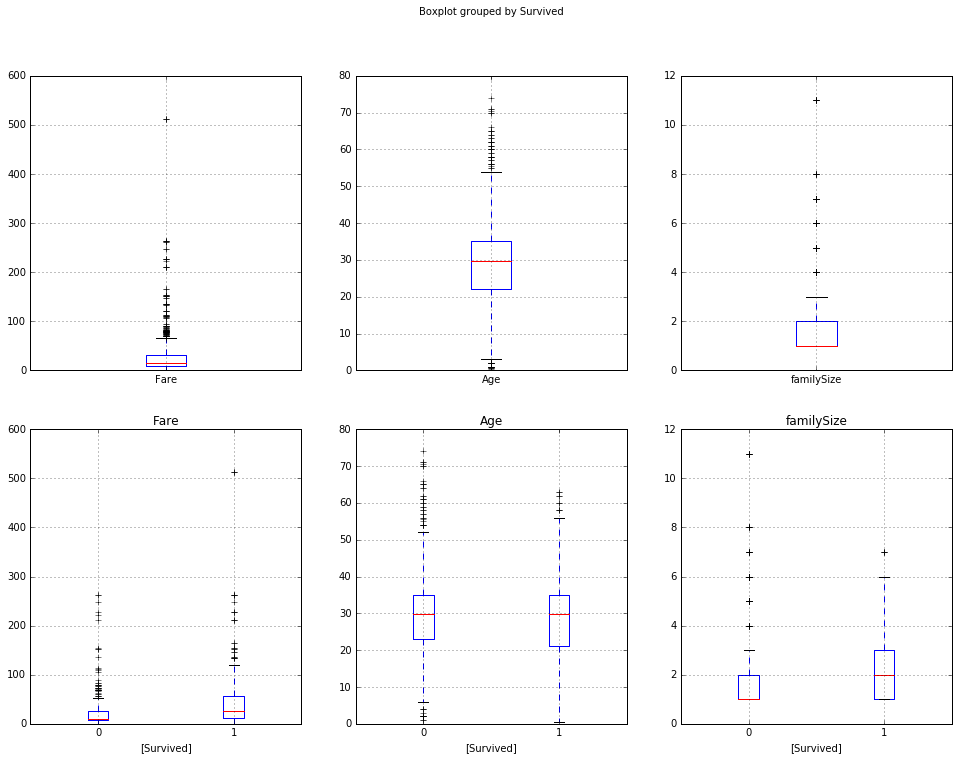

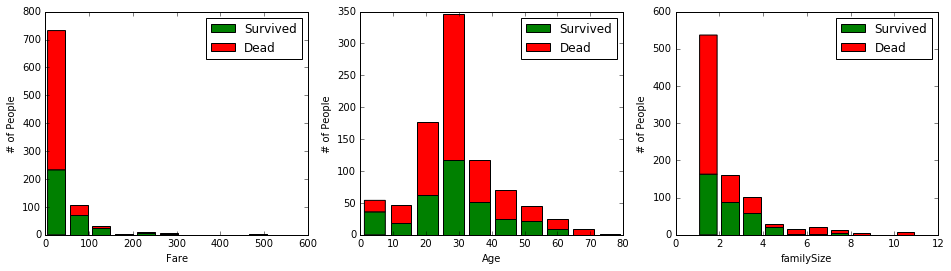

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(16,12))

train_data[["Fare"]].boxplot(ax=axes[0,0])
train_data[["Age"]].boxplot(ax=axes[0,1])
train_data[["familySize"]].boxplot(ax=axes[0,2])

train_data[["Fare","Survived"]].boxplot( by="Survived",ax=axes[1,0])
train_data[["Age","Survived"]].boxplot(by="Survived",ax=axes[1,1])
train_data[["familySize","Survived"]].boxplot(by="Survived",ax=axes[1,2])

plt.figure(figsize=[16,4])

plt.subplot(131)
plt.hist(x = [train_data[train_data['Survived']==1]['Fare'], train_data[train_data['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel("Fare")
plt.ylabel("# of People")
plt.legend()

plt.subplot(132)
plt.hist(x = [train_data[train_data['Survived']==1]['Age'], train_data[train_data['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel("Age")
plt.ylabel("# of People")
plt.legend()

plt.subplot(133)
plt.hist(x = [train_data[train_data['Survived']==1]['familySize'], train_data[train_data['Survived']==0]['familySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel("familySize")
plt.ylabel("# of People")
plt.legend()


In [22]:
models=[
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    
    neighbors.KNeighborsClassifier(),
    
    tree.DecisionTreeClassifier(),
    
    XGBClassifier()    
]

cv_split=model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)

models_columns=["m_Name","m_Parameters","m_Train_Accuracy_Mean","m_Test_Accuracy_Mean"]

models_df=pd.DataFrame(columns=models_columns)

m_predict=train_data[target]


    

In [24]:
row_ind=0
for item in models:
    model_name=item.__class__.__name__
    models_df.loc[row_ind, "m_Name"]=model_name
    models_df.loc[row_ind, "m_Parameters"]=str(item.get_params())
    
    cv_results=model_selection.cross_validate(item, train_data[bin_x_vals], 
                                              train_data[target], cv  = cv_split)
    
    models_df.loc[row_ind, "m_Train_Accuracy_Mean"]=cv_results["train_score"].mean()
    
    models_df.loc[row_ind, "m_Test_Accuracy_Mean"]=cv_results["test_score"].mean()
    
    item.fit(train_data[bin_x_vals],train_data[target])
    
    m_predict[model_name]=item.predict(train_data[bin_x_vals])
    row_ind+=1

F:\Anaconda\new\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda\new\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda\new\lib\site-packages\ipykernel\__main__.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
F:\Anaconda\new\lib\site-packages\sklearn\linear_model\ridge.py:1354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

In [26]:
models_df.sort_values(by = ['m_Test_Accuracy_Mean'], ascending = False, inplace = True)
models_df

,m_Name,m_Parameters,m_Train_Accuracy_Mean,m_Test_Accuracy_Mean
10,XGBClassifier,"{'reg_alpha': 0, 'colsample_bytree': 1, 'silen...",0.855618,0.827985
1,BaggingClassifier,"{'warm_start': False, 'max_samples': 1.0, 'bas...",0.890075,0.822388
2,ExtraTreesClassifier,"{'warm_start': False, 'oob_score': False, 'n_j...",0.895131,0.822388
9,DecisionTreeClassifier,"{'presort': False, 'splitter': 'best', 'min_im...",0.895131,0.822388
3,GradientBoostingClassifier,"{'presort': 'auto', 'loss': 'deviance', 'min_i...",0.867603,0.821642
4,RandomForestClassifier,"{'warm_start': False, 'oob_score': False, 'n_j...",0.890824,0.820149
8,KNeighborsClassifier,"{'n_neighbors': 5, 'n_jobs': 1, 'algorithm': '...",0.849251,0.81791
0,AdaBoostClassifier,"{'n_estimators': 50, 'base_estimator': None, '...",0.819663,0.810821
5,LogisticRegressionCV,"{'scoring': None, 'n_jobs': 1, 'verbose': 0, '...",0.792135,0.791418
6,RidgeClassifierCV,"{'normalize': False, 'alphas': (0.1, 1.0, 10.0...",0.790824,0.791045


##### Coin flip model 

In [54]:
import random
for index, row in train_data.iterrows():
    if random.random()>0.5:
        train_data.loc[index,"Random_Predict"]=1
    else:
        train_data.loc[index,"Random_Predict"]=0

coin_accuracy=float(len(train_data.loc[train_data["Random_Predict"]==train_data["Survived"]]))/float(len(train_data))
print 'Coin Flip Model Accuracy: {:.2f}%'.format(coin_accuracy*100)

Coin Flip Model Accuracy: 51.18%


In [55]:
pivot_female=train_data[train_data.Sex=="female"].groupby(['Sex','Pclass', 'Embarked','FareBin'])["Survived"].mean()
print 'Survival Decision Tree w/Female Node: '
print pivot_female

Survival Decision Tree w/Female Node: 
Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.953488
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000
 

In [49]:
pivot_male = train_data[train_data.Sex=='male'].groupby(['Sex','title'])['Survived'].mean()
print 'Survival Decision Tree w/male Node: '
print pivot_male

Survival Decision Tree w/male Node: 
Sex   title 
male  Master    0.575000
      Mr        0.156673
      Other     0.250000
Name: Survived, dtype: float64


In [56]:
def mytree(df):
    model=pd.DataFrame(data = {'Predict':[]})
    male_title="Master"
    
    for index,row in df.iterrows():
        model.loc[index,"Predict"]=0
        
        if df.loc[index,"Sex"]=="female":
            model.loc[index,"Predict"]=1
            
        if df.loc[index,"Sex"]=="female" and df.loc[index, 'Pclass'] == 3 and df.loc[index, 'Embarked'] == 'S' and df.loc[index, 'Fare'] > 8:
            model.loc[index,"Predict"]=0
         
        if df.loc[index, 'Sex'] == 'male' and df.loc[index, 'title'] == male_title:
            model.loc[index,"Predict"]=1
    return model
        
        
tree_predict=mytree(train_data)
print "Decision tree model accuracy Score: {:.2f} %".format(metrics.accuracy_score(train_data["Survived"],tree_predict)*100)
    

Decision tree model accuracy Score: 82.04 %


In [57]:
print metrics.classification_report(train_data["Survived"],tree_predict)

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



In [58]:
metrics.confusion_matrix(train_data["Survived"],tree_predict)

array([[497,  52],
       [108, 234]], dtype=int64)

Confusion matrix, without normalization
[[497  52]
 [108 234]]


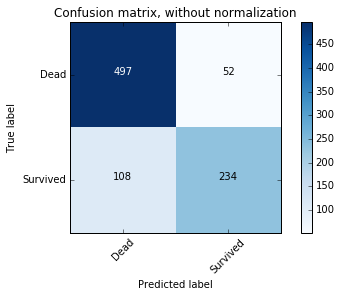

In [61]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(train_data["Survived"], tree_predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']

"""
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')
"""
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix



##### Tune Model with Hyper-Parameters 

In [69]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, train_data[bin_x_vals],train_data[target], cv  = cv_split)
dtree.fit(train_data[bin_x_vals],train_data[target])

print "DT Parameters(No hyper-parameters tuning):\n{}".format(dtree.get_params())
print    
print   
print "DT Test(No hyper-parameters tuning) w/bin score mean: {:.2f}%". format(base_results['test_score'].mean()*100)

DT Parameters(No hyper-parameters tuning):
{'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 0, 'min_impurity_split': None, 'max_features': None, 'max_depth': None, 'class_weight': None}


DT Test(No hyper-parameters tuning) w/bin score mean: 82.16%


In [71]:
#tune hyper-parameters
param_grid = {'criterion': ['gini', 'entropy'],  
              #'splitter': ['best', 'random'],
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], 
              #'min_samples_leaf': [1,5,10,.03,.05], 
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0]
             }

#print(list(model_selection.ParameterGrid(param_grid)))


tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(train_data[bin_x_vals],train_data[target])

print "DT Parameters(with hyper-parameters tuning):\n{}".format(tune_model.best_params_)
print    
print   
print "DT Test(with hyper-parameters tuning) w/bin score mean: {:.2f}%".format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100)

DT Parameters(with hyper-parameters tuning):
{'random_state': 0, 'criterion': 'gini', 'max_depth': 4}


DT Test(with hyper-parameters tuning) w/bin score mean: 87.63%


##### Tune Model with Feature Selection 

In [72]:
#base model
print "BEFORE DT RFE Columns old: "
print bin_x_vals
print   
print  
print "BEFORE DT RFE Test w/bin score mean: {:.2f}%". format(base_results['test_score'].mean()*100)

BEFORE DT RFE Columns old: 
['sexCode', 'Pclass', 'embarkedCode', 'titleCode', 'ageCode', 'fareCode', 'familySize']


BEFORE DT RFE Test w/bin score mean: 82.16%


In [78]:
#feature selection
dtree_rfe=feature_selection.RFECV(dtree,step=1, scoring="accuracy",cv=cv_split)
dtree_rfe.fit(train_data[bin_x_vals],train_data[target])

X_rfe = train_data[bin_x_vals].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree,train_data[X_rfe], train_data[target], cv  = cv_split)

print'AFTER DT RFE  Columns New: '
print X_rfe
print 
print

print "AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100)

AFTER DT RFE  Columns New: 
['sexCode' 'Pclass' 'titleCode' 'ageCode' 'fareCode' 'familySize']


AFTER DT RFE Test w/bin score mean: 83.10


In [81]:
#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(train_data[X_rfe], train_data[target])
print 'AFTER DT RFE Tuned Parameters: '
print rfe_tune_model.best_params_
print 
print
print "AFTER DT RFE Tuned Test w/bin score mean: {:.2f}%". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100)

AFTER DT RFE Tuned Parameters: 
{'random_state': 0, 'criterion': 'gini', 'max_depth': 4}


AFTER DT RFE Tuned Test w/bin score mean: 87.44%


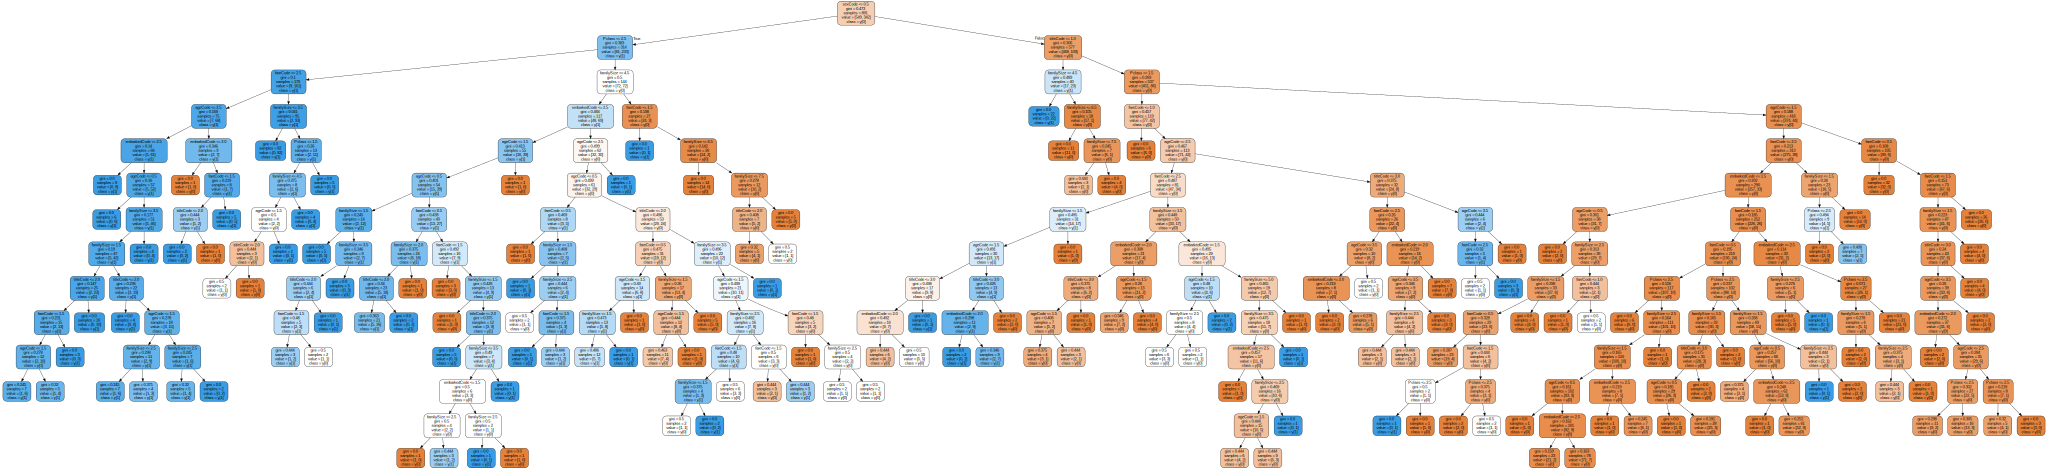

In [82]:
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = bin_x_vals, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph